# Assignment One (CS 7180)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 1. Load Data

In [2]:
# 1. Load MNIST training and test data from torchvision.datasets.MNIST.
# 2. Please use data.DataLoader and print out dataset size, sample size, batch size.
#******************************#

import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))  # normalizing the data
                               ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

#******************************#

print('dataset size: ', trainloader.sampler.num_samples + testloader.sampler.num_samples)
print('sample size:', trainloader.sampler.num_samples)
print('batch size: ', trainloader.batch_size)

num_classes = 10

dataset size:  70000
sample size: 60000
batch size:  32


### 2. Define Hyper-parameters

In [3]:
# Define hyper-parameters
#******************************#
dropout_pr = 0.2
stride = 1
padding = 1
kernel_size = 3  # filter size 3x3
num_filters1 = 8  # output channel from first convolutional layer
num_filters2 = 16  # output channel from second convolutional layer
maxpool_size = 2  # maxpooling size 2x2
num_h1 = 256  # dense hidden layer size 
n_epochs = 10
learning_rate = 0.01  # learning rate for SGD

#******************************#

final_image_size = int((28/maxpool_size)/maxpool_size)
# print(final_image_size)


### 3. Define a Convolutional Neural Network

In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # 3.1 Initialization
        #******************************#
        # conv layer: image tensor 28x28x1
        self.conv1 = nn.Conv2d(1, num_filters1, kernel_size, padding=padding)
        # batch normalization layer
        self.batchnorm1 = nn.BatchNorm2d(num_filters1)
        # conv layer: tensor 14x14x8
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size, padding=padding)
        # batch normalization layer
        self.batchnorm2 = nn.BatchNorm2d(num_filters2)
        # max pooling layer
        self.pool = nn.MaxPool2d(maxpool_size, maxpool_size)
        # linear layer: tensor 16x7x7
        self.fc1 = nn.Linear(num_filters2*final_image_size*final_image_size, num_h1)
        # linear layer: tensor 256x10
        self.fc2 = nn.Linear(num_h1, num_classes)
        # dropout layer: p=0.2
        self.dropout = nn.Dropout(dropout_pr)
        
        #******************************#
    def forward(self, x):
        # 3.2 Define Neural Network
        #******************************#
        # conv and max pooling layers
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))
        # flatten
        x = x.view(-1, num_filters2*final_image_size*final_image_size)
        # add dropout layer
        x = self.dropout(x)
        # add first hidden layer with relu
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add second dropout layer
        out = F.log_softmax(self.fc2(x), dim=1)
        #******************************#
        return out
    
model = ConvNet(num_classes).to(device)
# print(model)
# Note: what is the difference between 'same' and 'valid' padding? 
# Take a look at the outputs to understand the difference.

### 4. Training the Model

In [5]:
# 4.1 Define criterion and optimizer
#************************************#

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#************************************#


# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#
def train_model(n_epochs=10, save=False):
    """trains the model
    parameters:
    n_epoch: number of epochs
    save: if True, saves models is validation loss is decreased during an epoch
    """
    valid_loss_min = np.Inf # track change in validation loss

    train_losses = []
    test_losses = []
    accs = []

    for epoch in range(n_epochs):
        training_loss = 0  # loss for train data
        validation_loss = 0  # loss for test data
        accuracy = 0

        # train model
        model.train()
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)  # forward pass
            loss = criterion(output, target)  # calculate loss
            loss.backward()  # back propagate
            optimizer.step()  # optimizer step
            training_loss += loss.item()  # calculate training loss

        # validate model
        model.eval()
        for data, target in testloader:
            output = model(data)  # forward pass
            loss = criterion(output, target)  # calculate loss
            validation_loss += loss.item()  # calculate validation/test loss

            # accuracy
            out = torch.exp(output)
            top_p, top_class = out.topk(1, dim=1)  # take best class from the output
            equals = top_class == target.view(*top_class.shape)  #  check if class matches with target class
            accuracy += torch.mean(equals.type(torch.FloatTensor))  # calculate accuracy

        # calculate average loss and acuracy
        train_loss = training_loss/len(trainloader)
        valid_loss = validation_loss/len(testloader)
        accuracy_pc = accuracy/len(testloader)

        # save loss and accuracy for plotting
        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        accs.append(accuracy_pc)

        # print training/validation statistics 
        print('Epoch:{:2d}  Training Loss: {:.6f}\tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
            epoch+1, train_loss, valid_loss, accuracy_pc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            if n_epochs > 1: # no need to print if there is just 1 epoch
                print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            if save:  # saves the model
                torch.save(model.state_dict(), 'model_mnist.pt')
            valid_loss_min = valid_loss  # store minimum validation loss

    return train_losses, test_losses, accs 
            
#*******************************************#
# train the model for 10 epochs
train_losses, test_losses, accs = train_model(n_epochs=10, save=True) 

Epoch: 1  Training Loss: 0.342994	Validation Loss: 0.091686	Accuracy: 0.971146
		Validation loss decreased (inf --> 0.091686).  Saving model ...
Epoch: 2  Training Loss: 0.119985	Validation Loss: 0.057730	Accuracy: 0.981230
		Validation loss decreased (0.091686 --> 0.057730).  Saving model ...
Epoch: 3  Training Loss: 0.091903	Validation Loss: 0.049340	Accuracy: 0.984824
		Validation loss decreased (0.057730 --> 0.049340).  Saving model ...
Epoch: 4  Training Loss: 0.077596	Validation Loss: 0.042340	Accuracy: 0.986222
		Validation loss decreased (0.049340 --> 0.042340).  Saving model ...
Epoch: 5  Training Loss: 0.069906	Validation Loss: 0.041217	Accuracy: 0.986621
		Validation loss decreased (0.042340 --> 0.041217).  Saving model ...
Epoch: 6  Training Loss: 0.061360	Validation Loss: 0.035903	Accuracy: 0.987420
		Validation loss decreased (0.041217 --> 0.035903).  Saving model ...
Epoch: 7  Training Loss: 0.054226	Validation Loss: 0.032271	Accuracy: 0.989117
		Validation loss decrease

### 5. Model Evaluation

Number of parameters:  204826
Epoch	Training Loss	Validation Loss
1 	0.34299371 & 	0.09168640
2 	0.11998538 & 	0.05773036
3 	0.09190263 & 	0.04934031
4 	0.07759595 & 	0.04234007
5 	0.06990580 & 	0.04121702
6 	0.06135981 & 	0.03590280
7 	0.05422640 & 	0.03227065
8 	0.04953009 & 	0.03386303
9 	0.04777700 & 	0.03020406
10 	0.04437030 & 	0.02910404


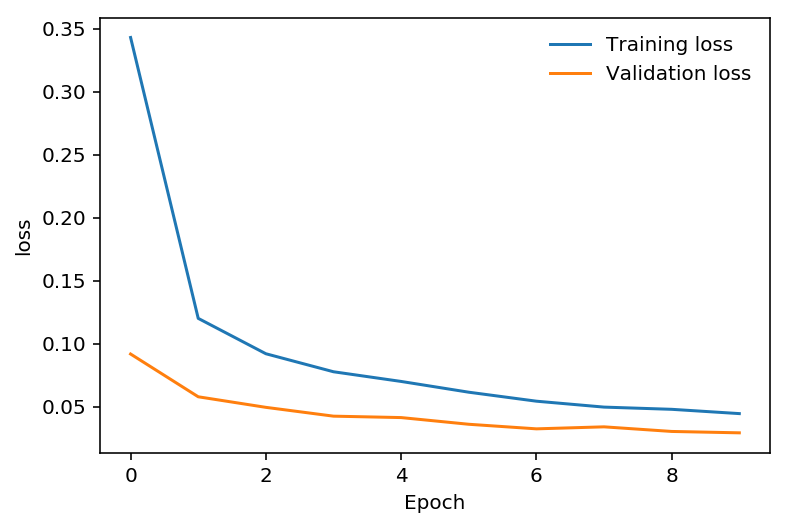

Epoch	Accuracy
1 	0.97114617
2 	0.98123002
3 	0.98482430
4 	0.98622203
5 	0.98662138
6 	0.98742014
7 	0.98911738
8 	0.98941696
9 	0.99011582
10 	0.99051517


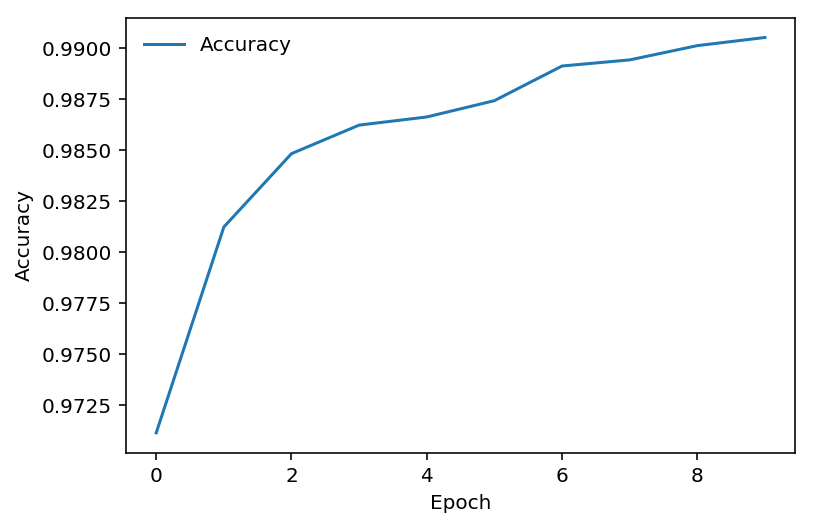

In [7]:
# 5.1 Print number of parameters in the model
#************************************#
highest_num_params = 1000000  # 1 Million 
# calculate number of parameters in used model
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: ', total_params)

# check if the number of parameters exceed the limitation
if highest_num_params < total_params:
    print('Parameter number exceeded than 1 million!')
#************************************#


# 5.2 Summarize history for loss and make loss vs.epoch plot
#************************************#
# print loss for each epoch
print('Epoch\tTraining Loss\tValidation Loss')
for i in range(n_epochs):
    print(i+1, '\t{:.8f} & \t{:.8f}'.format(train_losses[i], test_losses[i]))
    
# plot    
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()


#************************************#

# 5.3 Summarize history for accuracy and make accuracy vs.epoch plot
#************************************#
# print accuracy for each epoch
print('Epoch\tAccuracy')
for i in range(n_epochs):
    print(i+1, '\t{:.8f}'.format(accs[i]))

plt.plot(accs, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()
#************************************#

### 5. Varying dropout probabilities

In [8]:
# Set the probabilities of your dropout layers to 10 equally-spaced valuesp∈[0,1], 
# train for 1 epoch and report the final model accuracies for each.
#************************************#
p_list = np.linspace(0, 1, 10)

for pr in p_list:
    print('Dropout Probability: ', pr)
    # set dropout probability 
    dropout_pr = pr
    # initialize the model, loss and optimizer again 
    model = ConvNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # train the model for 1 epoch with the probability also prints the accuracy
    train_model(n_epochs=1, save=False)
    print('---------------------------------------------')
    
#************************************#

Dropout Probability:  0.0
Epoch: 1  Training Loss: 0.257634	Validation Loss: 0.090640	Accuracy: 0.972045
---------------------------------------------
Dropout Probability:  0.111111111111
Epoch: 1  Training Loss: 0.286351	Validation Loss: 0.080560	Accuracy: 0.976837
---------------------------------------------
Dropout Probability:  0.222222222222
Epoch: 1  Training Loss: 0.346497	Validation Loss: 0.085683	Accuracy: 0.974042
---------------------------------------------
Dropout Probability:  0.333333333333
Epoch: 1  Training Loss: 0.408794	Validation Loss: 0.094936	Accuracy: 0.969848
---------------------------------------------
Dropout Probability:  0.444444444444
Epoch: 1  Training Loss: 0.425644	Validation Loss: 0.103276	Accuracy: 0.967752
---------------------------------------------
Dropout Probability:  0.555555555556
Epoch: 1  Training Loss: 0.545243	Validation Loss: 0.113147	Accuracy: 0.967153
---------------------------------------------
Dropout Probability:  0.666666666667
Ep